In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNetCV
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Loading Data**

In [29]:
df=pd.read_csv('/content/drive/MyDrive/aids_project_dataset/diffractive_events.csv')
df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
ndf=pd.read_csv('/content/drive/MyDrive/aids_project_dataset/non_diffractive_events.csv')
ndf=ndf.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
df

,Event,ParticleID,Charged,pT,Eta,Phi,Rapidity,Energy,Class
0,0,-211,1,0.955392,3.273500,0.508232,3.262970,12.631800,1
1,0,-211,1,0.329022,-7.664530,-3.064370,-7.581800,350.638000,1
2,0,-211,1,0.465194,4.142840,2.565650,4.099770,14.653700,1
3,0,-321,1,0.416415,5.639280,-2.991790,5.200410,58.563100,1
4,0,2212,1,0.201472,6.810260,-2.922900,5.249370,91.383800,1
...,...,...,...,...,...,...,...,...,...
332930,4999,22,0,0.049179,0.663428,-2.103820,0.663428,0.060404,1
332931,4999,22,0,0.078913,3.749890,-0.075625,3.749890,1.678480,1
332932,4999,22,0,0.127283,3.358770,1.323830,3.358770,1.832150,1
332933,4999,22,0,0.135846,0.367001,0.219971,0.367001,0.145097,1


In [30]:
ndf

,Event,ParticleID,Charged,pT,Eta,Phi,Rapidity,Energy,Class
0,0,211,1,0.411630,6.581580,-2.114280,6.527170,148.533000,0
1,0,-211,1,0.201976,3.204790,1.299400,3.010390,2.497380,0
2,0,-211,1,0.081769,4.313030,0.158239,3.631340,3.056420,0
3,0,211,1,0.713790,3.240200,0.757945,3.221500,9.129710,0
4,0,-321,1,0.303322,8.028550,0.774174,7.381330,465.191000,0
...,...,...,...,...,...,...,...,...,...
552812,4999,22,0,0.252850,-1.289850,0.963092,-1.289850,0.494010,0
552813,4999,22,0,0.079990,-10.106500,1.511430,-10.106500,979.909000,0
552814,4999,22,0,0.054055,-8.913150,-2.889710,-8.913150,200.789000,0
552815,4999,22,0,0.058453,-0.738072,0.713808,-0.738072,0.075110,0


# **Data Preprocessing**


In [31]:
# Function to calculate the derived features for each event
def calculate_event_features(event_group):
    total_multiplicity = len(event_group)
    charged_multiplicity = event_group['Charged'].sum()

    features = {
        'TotalMultiplicity': total_multiplicity,
        'ChargedMultiplicity': charged_multiplicity,
        'ChargeRatio': charged_multiplicity / total_multiplicity if total_multiplicity != 0 else 0,  # New feature
        'Mean_pT': event_group['pT'].mean(),
        'Var_pT': event_group['pT'].var(),
        'Mean_Eta': event_group['Eta'].mean(),
        'Var_Eta': event_group['Eta'].var(),
        'Mean_Phi': event_group['Phi'].mean(),
        'Var_Phi': event_group['Phi'].var(),
        'Mean_Rapidity': event_group['Rapidity'].mean(),
        'Var_Rapidity': event_group['Rapidity'].var(),
        'TotalEnergy': event_group['Energy'].sum(),
        'EnergyRatio': event_group['Energy'].max() / event_group['Energy'].sum() if event_group['Energy'].sum() != 0 else 0,
        'AngularCorrelation': event_group['Phi'].corr(event_group['Eta']),
        'Class': event_group['Class'].iloc[0]  # Assuming Class is the same for all particles in an event
    }
    return pd.Series(features)

# Group by the 'Event' column and calculate features
df = df.groupby('Event').apply(calculate_event_features).reset_index()
ndf = ndf.groupby('Event').apply(calculate_event_features).reset_index()

# Display the resulting DataFrame
df


<ipython-input-31-0de011c5657f>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Event').apply(calculate_event_features).reset_index()
<ipython-input-31-0de011c5657f>:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ndf = ndf.groupby('Event').apply(calculate_event_features).reset_index()


,Event,TotalMultiplicity,ChargedMultiplicity,ChargeRatio,Mean_pT,Var_pT,Mean_Eta,Var_Eta,Mean_Phi,Var_Phi,Mean_Rapidity,Var_Rapidity,TotalEnergy,EnergyRatio,AngularCorrelation,Class
0,0,53.0,32.0,0.603774,0.363084,0.070728,1.818355,31.338007,-0.569602,3.091549,1.656540,29.607441,12999.988984,0.296676,-0.102322,1.0
1,1,33.0,18.0,0.545455,0.322879,0.071706,1.823049,47.013636,0.060245,3.375409,1.816435,43.481947,13000.003002,0.176643,0.111909,1.0
2,2,43.0,18.0,0.418605,0.307145,0.076143,4.031273,13.764702,0.203525,3.195693,3.938845,12.238225,13000.009945,0.499945,0.023580,1.0
3,3,197.0,88.0,0.446701,0.313250,0.096179,1.419807,10.433718,-0.044408,3.143901,1.421220,9.526779,12999.992211,0.489953,0.017070,1.0
4,4,3.0,2.0,0.666667,0.310554,0.019278,2.588030,133.561711,-0.219844,6.366375,2.319850,105.888377,12999.999000,0.500000,0.962296,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,45.0,20.0,0.444444,0.309422,0.046363,-3.766042,13.676147,-0.199799,3.539038,-3.688064,11.572227,13000.000320,0.499926,-0.128925,1.0
4996,4996,354.0,162.0,0.457627,0.340171,0.105253,-0.688341,8.682219,0.040734,3.726215,-0.656832,7.945078,12999.999638,0.474789,-0.018105,1.0
4997,4997,107.0,44.0,0.411215,0.309752,0.078595,-1.546585,9.613963,-0.004394,3.564884,-1.534029,8.577181,12999.995240,0.496789,-0.050025,1.0
4998,4998,25.0,16.0,0.640000,0.259252,0.031996,-5.787620,17.212731,0.251112,3.049864,-5.694276,13.037669,13000.004940,0.499998,-0.088427,1.0


In [32]:
data=pd.concat([df,ndf])
data = data.sample(frac=1).reset_index(drop=True)
data = data.drop(['Event', 'TotalEnergy'], axis=1)
data

,TotalMultiplicity,ChargedMultiplicity,ChargeRatio,Mean_pT,Var_pT,Mean_Eta,Var_Eta,Mean_Phi,Var_Phi,Mean_Rapidity,Var_Rapidity,EnergyRatio,AngularCorrelation,Class
0,6.0,4.0,0.666667,0.195588,0.011321,-5.827867,74.005768,-0.707336,4.048781,-5.714678,56.113761,0.500000,-0.514476,1.0
1,102.0,50.0,0.490196,0.266579,0.049281,0.459574,30.061081,-0.251010,2.932390,0.547443,27.279500,0.191717,-0.078023,0.0
2,70.0,32.0,0.457143,0.262590,0.037934,1.524560,23.058085,0.462862,2.923997,1.483672,21.558550,0.419853,0.088309,0.0
3,85.0,48.0,0.564706,0.327871,0.047204,-1.056724,27.153988,-0.054795,3.176911,-1.013911,24.874633,0.183350,-0.026835,0.0
4,50.0,22.0,0.440000,0.323466,0.074140,2.849573,13.211127,0.080194,3.459018,2.666372,11.755703,0.499622,-0.018888,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,74.0,28.0,0.378378,0.360642,0.106279,2.297552,17.134144,-0.152071,3.366778,2.270431,16.056429,0.316515,0.175832,1.0
9996,91.0,50.0,0.549451,0.422103,0.181174,2.872714,8.783877,-0.003509,3.156835,2.806827,8.322325,0.499290,-0.104381,1.0
9997,71.0,32.0,0.450704,0.280247,0.056105,-1.737493,29.547262,-0.037849,3.529516,-1.756696,27.640181,0.237517,0.040889,0.0
9998,7.0,6.0,0.857143,0.186093,0.013667,-3.027569,81.295093,-0.741264,2.729257,-2.788737,63.764326,0.469778,-0.583127,1.0


In [33]:
X = data.drop('Class', axis=1)  # Features are all columns except 'class'
y = data['Class']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_data_df = pd.DataFrame(scaled_data, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(scaled_data_df, y, test_size=0.2, random_state=42)

# **Feature Selection**

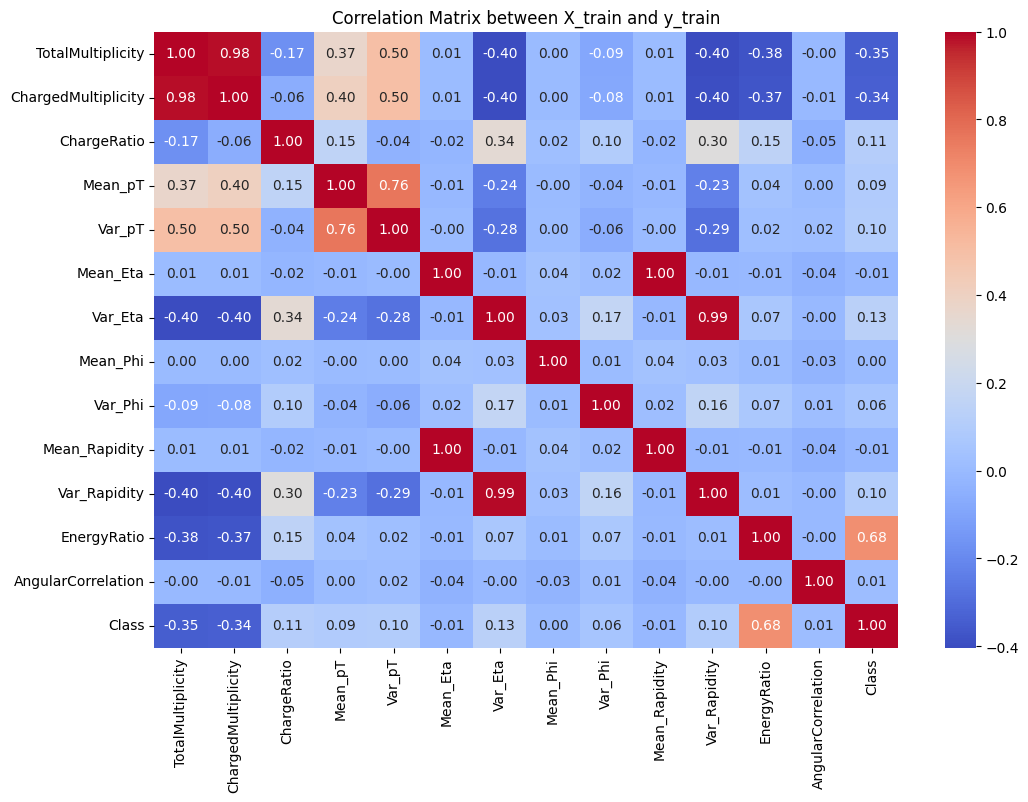

In [34]:
data_combined = pd.concat([X_train, y_train], axis=1)

# Compute correlation matrix
correlation_matrix = data_combined.corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix between X_train and y_train")
plt.show()

In [35]:
# Initialize and train the XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_clf.fit(X_train, y_train)

# Get feature importance
importance = xgb_clf.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(feature_importance_df)

                Feature  Importance
11          EnergyRatio    0.417333
0     TotalMultiplicity    0.193487
10         Var_Rapidity    0.077747
1   ChargedMultiplicity    0.063591
5              Mean_Eta    0.055956
6               Var_Eta    0.051541
9         Mean_Rapidity    0.047574
4                Var_pT    0.022824
3               Mean_pT    0.018196
8               Var_Phi    0.015102
2           ChargeRatio    0.012294
12   AngularCorrelation    0.012179
7              Mean_Phi    0.012176


In [36]:
# Train a Random Forest classifier with RFE
estimator = RandomForestClassifier(random_state=42)
selector = RFE(estimator, n_features_to_select=5, step=1)  # Select top 5 features
selector = selector.fit(X_train, y_train)

# Print selected features
selected_features = X_train.columns[selector.support_]
print("Selected Features:", selected_features)


Selected Features: Index(['TotalMultiplicity', 'ChargedMultiplicity', 'Var_Eta', 'Var_Rapidity',
       'EnergyRatio'],
      dtype='object')


100%|===================| 7982/8000 [00:43<00:00]       

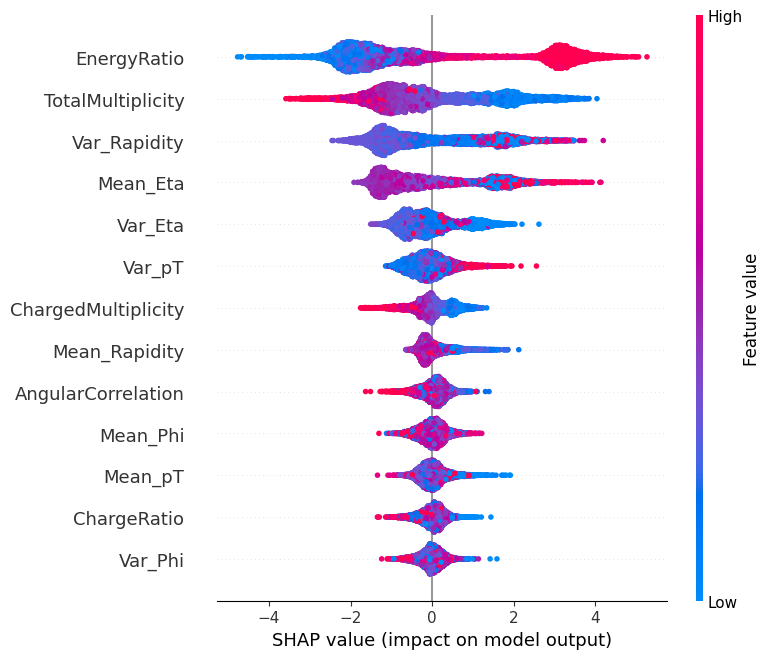

In [37]:
model = XGBClassifier()  # or any trained model
model.fit(X_train, y_train)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)  # Feature importance summary


In [38]:
X_train=X_train[['TotalMultiplicity', 'ChargedMultiplicity', 'Mean_Eta', 'Var_Rapidity',
'EnergyRatio']]
X_test=X_test[['TotalMultiplicity', 'ChargedMultiplicity', 'Mean_Eta', 'Var_Rapidity',
'EnergyRatio']]

## **Random Forest**

In [39]:
# Define a parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='accuracy',       # Scoring metric for evaluation
    cv=3,                     # 3-fold cross-validation (reduce folds)
    verbose=1,                # Show progress during grid search
    n_jobs=-1                 # Use all available cores
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Make predictions on the test set using the best model
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 91.55%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       999
         1.0       0.95      0.88      0.91      1001

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



# **XGBoost**

In [40]:
# Initialize the XGBClassifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1]
}


# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
Accuracy: 91.85%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.96      0.92       999
         1.0       0.95      0.88      0.92      1001

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:37:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# **Support Vector Machines**

In [41]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'degree': [3, 4],
    'coef0': [0.0, 0.1],
    'class_weight': [None, 'balanced']
}

# Initialize the SVM classifier
svm_model = SVC(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_svm_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Make predictions on the test set using the best model
y_pred = best_svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Parameters: {'C': 10, 'class_weight': 'balanced', 'coef0': 0.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 92.00%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92       999
         1.0       0.96      0.88      0.92      1001

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



# **MLP Neural Network**

In [42]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(50,), (50, 50)],  # Single and multi-layer configurations
    'activation': ['relu'],  # Most common activation
    'solver': ['adam'],  # Adam optimizers
    'alpha': [0.001, 0.01],  # Regularization strength
    'learning_rate': ['adaptive'],  # Types of learning rate schedules
    'max_iter': [300]  # Number of iterations
}


# Initialize the MLP classifier
mlp_model = MLPClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_mlp_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Make predictions on the test set using the best model
y_pred = best_mlp_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 300, 'solver': 'adam'}
Accuracy: 91.75%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       999
         1.0       0.95      0.88      0.91      1001

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



# **Introducing a New Feature: Rapidity Gap**

In [64]:
df=pd.read_csv('/content/drive/MyDrive/aids_project_dataset/diffractive_events.csv')
df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
ndf=pd.read_csv('/content/drive/MyDrive/aids_project_dataset/non_diffractive_events.csv')
ndf=ndf.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

# Function to calculate the derived features for each event, including MaxRapidityGap
def calculate_event_features(event_group):
    total_multiplicity = len(event_group)
    charged_multiplicity = event_group['Charged'].sum()

    # Calculate the MaxRapidityGap (max gap between consecutive rapidities)
    rapidities = event_group['Rapidity'].sort_values().tolist()  # Sort rapidities in ascending order
    max_rapidity_gap = 0
    if len(rapidities) > 1:
        # Calculate the gaps between consecutive rapidities
        for i in range(len(rapidities) - 1):
            gap = rapidities[i + 1] - rapidities[i]
            if gap > max_rapidity_gap:
                max_rapidity_gap = gap

    features = {
        'TotalMultiplicity': total_multiplicity,
        'ChargedMultiplicity': charged_multiplicity,
        'ChargeRatio': charged_multiplicity / total_multiplicity if total_multiplicity != 0 else 0,  # New feature
        'Mean_pT': event_group['pT'].mean(),
        'Var_pT': event_group['pT'].var(),
        'Mean_Eta': event_group['Eta'].mean(),
        'Var_Eta': event_group['Eta'].var(),
        'Mean_Phi': event_group['Phi'].mean(),
        'Var_Phi': event_group['Phi'].var(),
        'Mean_Rapidity': event_group['Rapidity'].mean(),
        'Var_Rapidity': event_group['Rapidity'].var(),
        'TotalEnergy': event_group['Energy'].sum(),
        'EnergyRatio': event_group['Energy'].max() / event_group['Energy'].sum() if event_group['Energy'].sum() != 0 else 0,
        'AngularCorrelation': event_group['Phi'].corr(event_group['Eta']),
        'MaxRapidityGap': max_rapidity_gap,  # New feature
        'Class': event_group['Class'].iloc[0]  # Assuming Class is the same for all particles in an event
    }
    return pd.Series(features)

# Group by the 'Event' column and calculate features
df = df.groupby('Event').apply(calculate_event_features).reset_index()
ndf = ndf.groupby('Event').apply(calculate_event_features).reset_index()

data=pd.concat([df,ndf])
data = data.sample(frac=1).reset_index(drop=True)
data = data.drop(['Event', 'TotalEnergy'], axis=1)
data



<ipython-input-64-ca09afa83b2e>:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Event').apply(calculate_event_features).reset_index()
<ipython-input-64-ca09afa83b2e>:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ndf = ndf.groupby('Event').apply(calculate_event_features).reset_index()


,TotalMultiplicity,ChargedMultiplicity,ChargeRatio,Mean_pT,Var_pT,Mean_Eta,Var_Eta,Mean_Phi,Var_Phi,Mean_Rapidity,Var_Rapidity,EnergyRatio,AngularCorrelation,MaxRapidityGap,Class
0,68.0,28.0,0.411765,0.312908,0.110939,-2.750082,12.708644,0.030491,3.646753,-2.649707,11.562570,0.431174,-0.106344,8.476208,1.0
1,73.0,38.0,0.520548,0.274957,0.080889,-0.092102,26.590292,0.152810,3.499555,-0.067428,23.221030,0.248645,-0.089782,1.396020,0.0
2,106.0,46.0,0.433962,0.266987,0.043358,0.821518,31.885583,-0.011613,3.313072,0.881037,29.744837,0.152591,-0.035357,1.611380,0.0
3,5.0,2.0,0.400000,0.412356,0.162550,-5.368962,83.733689,-0.289638,3.412137,-5.235016,68.925949,0.500000,-0.015270,17.116980,1.0
4,95.0,46.0,0.484211,0.335246,0.072733,-1.503647,19.125629,-0.469461,3.607963,-1.499690,17.162599,0.200089,0.097935,4.047030,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,100.0,44.0,0.440000,0.250322,0.043008,0.177419,25.225877,-0.163295,3.492498,0.202962,23.690351,0.226389,0.015097,1.716000,0.0
9996,150.0,74.0,0.493333,0.420356,0.137345,0.332863,20.241286,-0.062486,3.019856,0.341547,18.709972,0.156560,0.156934,0.928720,0.0
9997,121.0,42.0,0.347107,0.251179,0.055926,-0.730375,27.092619,0.250218,3.536140,-0.721742,25.711922,0.241829,0.015343,0.826940,0.0
9998,68.0,34.0,0.500000,0.328770,0.077185,0.588604,25.162270,-0.116640,2.987090,0.508305,23.021381,0.308077,0.165327,2.876422,1.0


In [65]:
X = data.drop('Class', axis=1)  # Features are all columns except 'class'
y = data['Class']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_data_df = pd.DataFrame(scaled_data, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(scaled_data_df, y, test_size=0.2, random_state=42)

In [66]:
# Initialize and train the XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_clf.fit(X_train, y_train)

# Get feature importance
importance = xgb_clf.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(feature_importance_df)

                Feature  Importance
13       MaxRapidityGap    0.735947
6               Var_Eta    0.037494
10         Var_Rapidity    0.033389
11          EnergyRatio    0.028225
4                Var_pT    0.021774
0     TotalMultiplicity    0.018720
1   ChargedMultiplicity    0.017769
3               Mean_pT    0.017524
2           ChargeRatio    0.015696
9         Mean_Rapidity    0.015461
8               Var_Phi    0.015184
12   AngularCorrelation    0.015054
5              Mean_Eta    0.014686
7              Mean_Phi    0.013076


In [67]:
X_train=X_train[['MaxRapidityGap']]
X_test=X_test[['MaxRapidityGap']]

In [68]:
# Initialize the XGBClassifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1]
}


# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Accuracy: 94.05%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      1023
         1.0       0.95      0.93      0.94       977

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:51:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
